In [1]:
import pandas as pd
import numpy as np
import netCDF4
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from ipywidgets import interact  #, interactive, fixed, interact_manual
import ipywidgets as widgets
import utils

In [2]:
output_dir = "output_final/dbscan/interpretation/"

# load data
variant = "A1"
df = pd.read_csv(output_dir.removesuffix("interpretation/") + f"post_processing/re-assigned_{variant}.csv")
nc = netCDF4.Dataset(output_dir.removesuffix("interpretation/") + f'post_processing/regions_{variant}.nc')

In [3]:
# description of all labels (compute statistics without re-assigned points, they might distribu statistics)
descr = df[~df["re-assigned"]].groupby("label").describe()
descr.to_csv(output_dir + "description.csv", index=False)

# Complete area

In [4]:
# defining our area of interest
lat_min = 0
lat_max = 70

lon_min = -77
lon_max = 30

# plot settings
factor = 12
mymap = Basemap(llcrnrlon=lon_min, llcrnrlat=lat_min, urcrnrlon=lon_max, urcrnrlat=lat_max)
plt.rcParams["figure.figsize"] = ((lon_max - lon_min)/factor, (lat_max - lat_min)/factor)

# plot
def plot_over_depth(depth_level):
    hex_colors = nc["color"][depth_level, :, :]  #.data
    rgb = np.array([[matplotlib.colors.to_rgb(color) if type(color) == str and color is not None and color != "" else np.array([1, 1, 1]) for color in row] for row in hex_colors])
    mymap.imshow(rgb)  # , cmap=cm, vmin=vmin, vmax=vmax)
    mymap.drawcoastlines(linewidth=0.5)
    mymap.fillcontinents()
    mymap.drawparallels(np.arange(int(lat_min),int(lat_max), 10),labels=[1,0,0,0])
    mymap.drawmeridians(np.arange(int(lon_min),int(lon_max), 10),labels=[0,0,0,1])
    plt.tight_layout()
    # plt.savefig(output_dir + "my_surface.png")

depth_levels = np.array((range(nc["LEV_M"].shape[0])))
interact(plot_over_depth, depth_level=widgets.IntSlider(value=depth_levels.min(), min=depth_levels.min(), max=depth_levels.max(), step=1))

plt.show()

interactive(children=(IntSlider(value=0, description='depth_level', max=11), Output()), _dom_classes=('widget-…

In [5]:
# # defining our area and inspecting deep North Atlantic
# lat_min = df.LATITUDE.min()
# lat_max = df.LATITUDE.max()

# lon_min = df.LONGITUDE.min()
# lon_max = df.LONGITUDE.max()

# depths = df.LEV_M.unique()

# # select above area from df and set basic plotting parameters
# factor = 12
# df_region = df[(df.LONGITUDE <= lon_max) &  (df.LONGITUDE >= lon_min) & (df.LATITUDE <= lat_max) & (df.LATITUDE >= lat_min)]
# mymap = Basemap(llcrnrlon=lon_min, llcrnrlat=lat_min, urcrnrlon=lon_max, urcrnrlat=lat_max)
# plt.rcParams["figure.figsize"] = ((lon_max - lon_min)/factor, (lat_max - lat_min)/factor)

# def plot_wms_over_depth(depth_level):
#     # filter for depth
#     d = depths[depth_level]
#     temp = df_region[df_region.LEV_M == d]
#     print(d)

#     # plot
#     fig, ax = plt.subplots()
#     # mymap.etopo()
#     ax.scatter(temp.LONGITUDE, temp.LATITUDE, color=temp.color, s=20, alpha=0.8)#, cmap=cm, vmin=vmin, vmax=vmax)
#     mymap.drawcoastlines(linewidth=0.5)
#     mymap.fillcontinents()
#     mymap.drawparallels(np.arange(int(lat_min),int(lat_max), 10),labels=[1,0,0,0])
#     mymap.drawmeridians(np.arange(int(lon_min),int(lon_max), 10),labels=[0,0,0,1])
#     plt.tight_layout()
#     plt.savefig("our_surface.png")

# interact(plot_wms_over_depth, depth_level=widgets.IntSlider(value=0, min=0, max=len(depths)-1, step=1))

# plt.show()

# Mediterranean Sea

In [6]:
# Mediterranean Sea extent
lon_min = -6
lon_max = 30

lat_min = 30
lat_max = 48

medi = df[(df.LONGITUDE <= lon_max) &  (df.LONGITUDE >= lon_min) & (df.LATITUDE <= lat_max) & (df.LATITUDE >= lat_min)]
medi = medi.drop(medi[(medi.LONGITUDE < 0) & (medi.LATITUDE > 42)].index)  # cut out Biskaya
medi = medi.drop(medi[(medi.LONGITUDE > 27) & (medi.LATITUDE > 40)].index) # cut out Red Sea

In [7]:
print(f"Number of clusters: {len(medi.label.unique())}")
print(f"Number of grid cells per cluster: ")
medi.label.value_counts()

Number of clusters: 12
Number of grid cells per cluster: 


label
34    2407
0       76
14      42
29      14
92       6
42       5
15       4
36       3
7        1
8        1
1        1
61       1
Name: count, dtype: int64

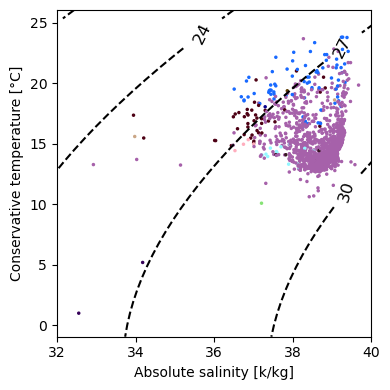

In [8]:
utils.plot_ts(medi, figsize=(4, 4), xlim=(32, 40), save_as=output_dir + "ts_mediterranean.png")

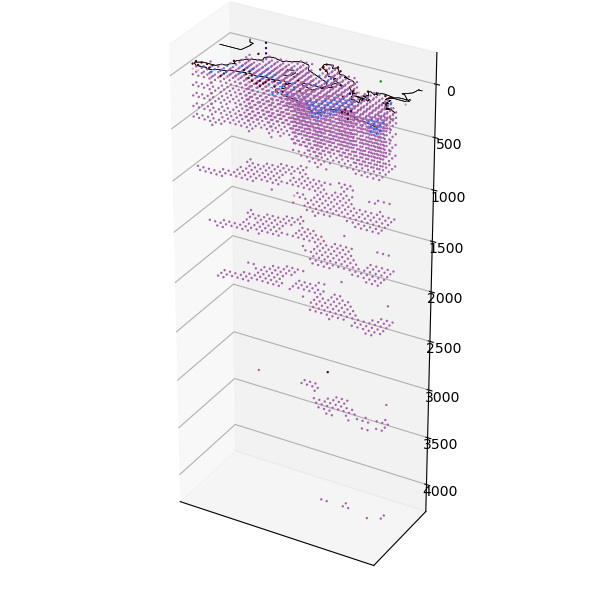

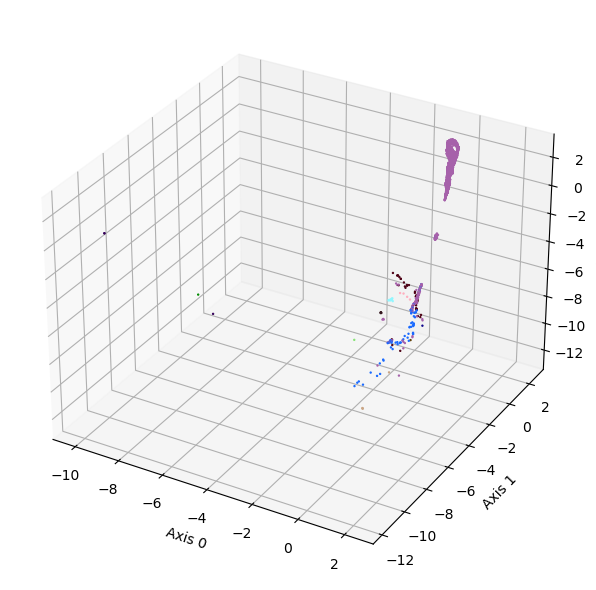

In [9]:
utils.coupled_label_plot(medi)

# Deep North Atlantic

In [10]:
# define extent
lat_min = df.LATITUDE.min()
lat_max = df.LATITUDE.max()

lon_min = df.LONGITUDE.min()
lon_max = df.LONGITUDE.max()

depths = df.LEV_M.unique()[-2:]

dna = df.drop(medi.index)  # remove Mediterranean
dna = dna[dna.LONGITUDE <= 14] # cut out Red Sea
dna = dna[dna.LEV_M.isin(depths)]  # only look at deep areas

In [11]:
print(f"Number of clusters: {len(dna.label.unique())}")
print(f"Number of grid cells per cluster: ")
dna.label.value_counts()

Number of clusters: 10
Number of grid cells per cluster: 


label
282    2842
249    1484
67      287
209     144
203     126
274     124
131      74
161      17
124       8
16        6
Name: count, dtype: int64

In [12]:
print(2842/len(dna)*100)
print(1484/len(dna)*100)

55.59467918622848
29.029733959311425


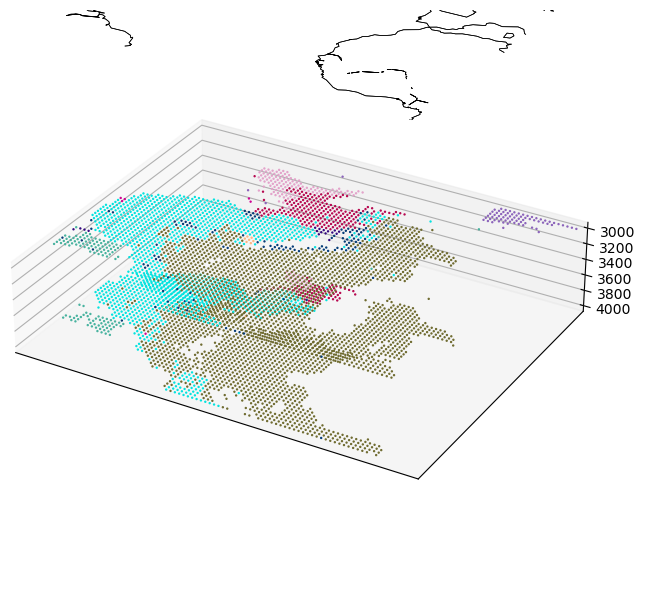

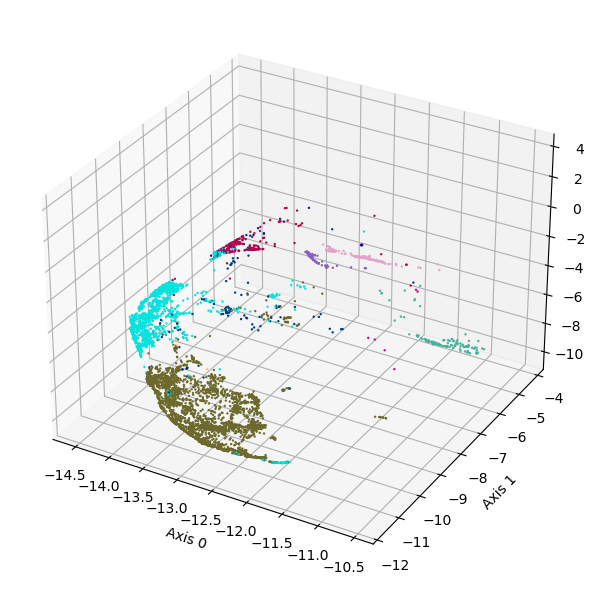

In [13]:
utils.coupled_label_plot(dna)

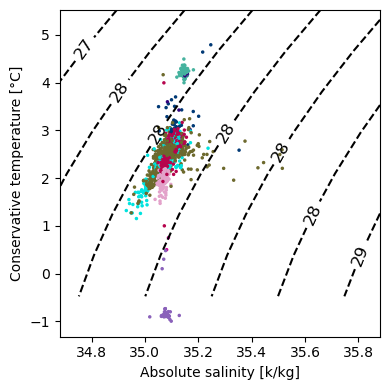

In [14]:
utils.plot_ts(dna, figsize=(4, 4), save_as=output_dir + "ts_deep_north_atlantic.png")#, xlim=(32, 40), save_as=None)

# Labrador Sea

In [15]:
# extent
lon_min = df.LONGITUDE.min()
lon_max = -40

lat_min = 45
lat_max = df.LATITUDE.max()

lab = df[(df.LONGITUDE <= lon_max) &  (df.LONGITUDE >= lon_min) & (df.LATITUDE <= lat_max) & (df.LATITUDE >= lat_min)]

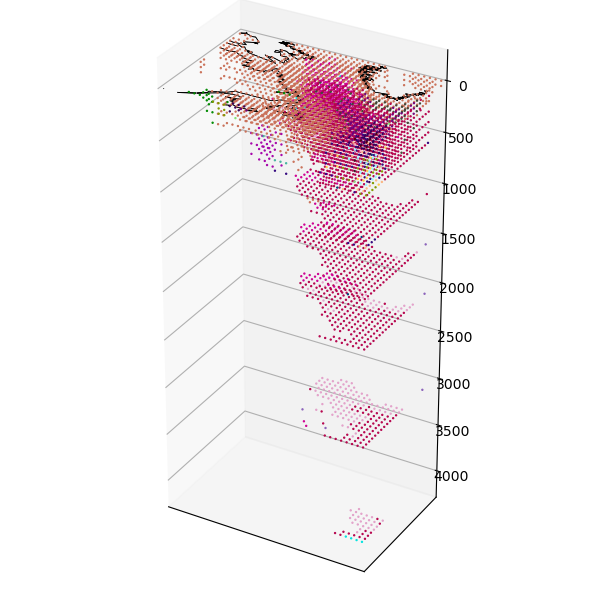

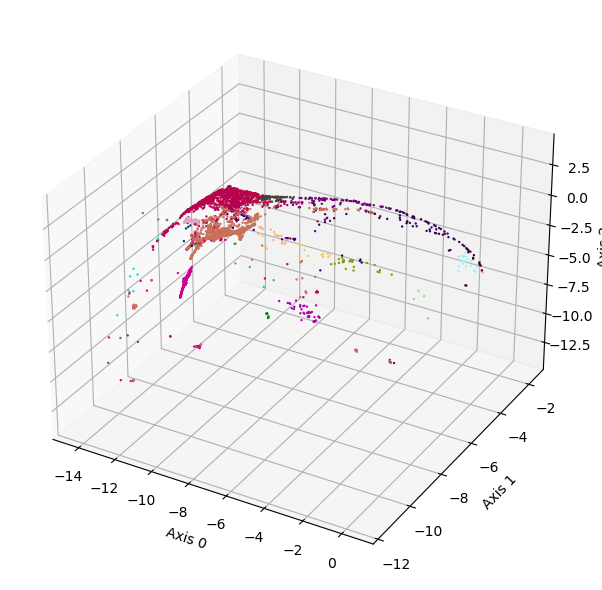

In [16]:
utils.coupled_label_plot(lab)

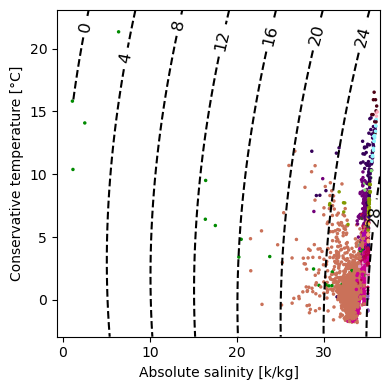

In [17]:
utils.plot_ts(lab, save_as=output_dir + "ts_labrador.png")